In [1]:
import tensorflow as tf

import os
import tensorflow_datasets as tfds

In [2]:
from google.colab  import drive
drive.mount("/gdrive")
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [3]:
directory_path='/gdrive/My Drive/Yedek/Video_Dataset_hsv'

In [4]:
subset_paths={'train':directory_path+'/train','test':directory_path+'/test'}

In [5]:
!pip install hickle
import hickle as hkl
import random
from pathlib import Path
import os
import cv2
import matplotlib.pyplot as plt
from random import randint
import numpy as np
import matplotlib.pyplot as plt

In [6]:
def frames_from_video_file(video_path):
  result = []
  src = cv2.VideoCapture(str(video_path))

  for _ in range(1,20,9):
    ret, frame = src.read()
    frame = tf.image.convert_image_dtype(frame, tf.float32)
    tf.image.resize(frame, [456,456])
    result.append(frame)
  src.release()
  result = np.array(result)[..., [2, 1, 0]]
  return result

In [7]:
class FrameGenerator:
  def __init__(self, path, training = False):

    self.path = path
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths]
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path)
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [8]:
train_path = Path(subset_paths['train'])
test_path = Path(subset_paths['test'])

In [9]:
fg = FrameGenerator(train_path, training=True)
print(fg.class_ids_for_name)

{'healthy': 0, 'sick': 1}


In [10]:
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.float32))

In [11]:
train_ds = tf.data.Dataset.from_generator(FrameGenerator(train_path, training=True),
                                          output_signature = output_signature)
test_ds = tf.data.Dataset.from_generator(FrameGenerator(test_path, training=False),
                                          output_signature = output_signature)

In [12]:
train_ds = train_ds.batch(8)
test_ds = test_ds.batch(8)

train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

test_frames, test_labels = next(iter(test_ds))
print(f'Shape of validation set of frames: {test_frames.shape}')
print(f'Shape of validation labels: {test_labels.shape}')

Shape of training set of frames: (8, 3, 480, 640, 3)
Shape of training labels: (8,)
Shape of validation set of frames: (8, 3, 480, 640, 3)
Shape of validation labels: (8,)


In [13]:
def build_efficient():
    inputs = tf.keras.layers.Input(shape=(456, 456, 3))
    model = tf.keras.applications.EfficientNetB5(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    model = tf.keras.Sequential([model,tf.keras.layers.GlobalAveragePooling2D(),tf.keras.layers.BatchNormalization()])

    return model

In [14]:
net=build_efficient()

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=255),
    tf.keras.layers.TimeDistributed(net),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(1,'sigmoid')
])

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='mse', metrics=tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', dtype=None, threshold=0.5))

In [15]:
epochs=10

In [16]:
model.fit(train_ds, epochs = epochs)

Epoch 1/10
22/22 [==============================] - 94s 2s/step - loss: 0.2082 - binary_accuracy: 0.6477
Epoch 2/10
22/22 [==============================] - 49s 2s/step - loss: 0.1229 - binary_accuracy: 0.8352
Epoch 3/10
22/22 [==============================] - 49s 2s/step - loss: 0.0818 - binary_accuracy: 0.8920
Epoch 4/10
22/22 [==============================] - 49s 2s/step - loss: 0.0885 - binary_accuracy: 0.8864
Epoch 5/10
22/22 [==============================] - 49s 2s/step - loss: 0.0613 - binary_accuracy: 0.9375
Epoch 6/10
22/22 [==============================] - 50s 2s/step - loss: 0.0741 - binary_accuracy: 0.8920
Epoch 7/10
22/22 [==============================] - 50s 2s/step - loss: 0.0895 - binary_accuracy: 0.8864
Epoch 8/10
22/22 [==============================] - 50s 2s/step - loss: 0.0624 - binary_accuracy: 0.9091
Epoch 9/10
22/22 [==============================] - 50s 2s/step - loss: 0.0659 - binary_accuracy: 0.9091
Epoch 10/10
22/22 [==============================] - 50

In [17]:
def get_actual_predicted_labels(dataset):
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [19]:
model.evaluate(test_ds ,return_dict=True)

10/10 [==============================] - 22s 1s/step - loss: 0.0899 - binary_accuracy: 0.8816


{'loss': 0.08994877338409424, 'binary_accuracy': 0.8815789222717285}

In [20]:
actual

<tf.Tensor: shape=(76,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>

In [22]:
import seaborn as sns

In [27]:
y_pred=model.predict(test_ds)
y_pred=np.where(y_pred > 0.5, 1,0)

10/10 [==============================] - 15s 2s/step


In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report

cm=confusion_matrix(actual, y_pred)
print(cm)
print(classification_report(actual, y_pred))

[[43  5]
 [ 4 24]]
              precision    recall  f1-score   support

         0.0       0.91      0.90      0.91        48
         1.0       0.83      0.86      0.84        28

    accuracy                           0.88        76
   macro avg       0.87      0.88      0.87        76
weighted avg       0.88      0.88      0.88        76



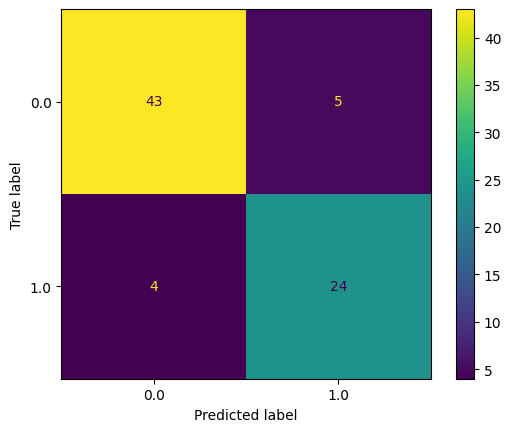

In [30]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0.0','1.0'])
sns.reset_orig()
disp.plot()